In [2]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('fivethirtyeight')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 1000, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mp.style.use('ggplot')
sns.set(style='whitegrid')

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA 
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNet, Ridge, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

/Users/april/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
df = pd.read_json('input/CleanedData.json', orient='table')
df = df[[c for c in df if c not in ['loan_status']] + ['loan_status']]

In [4]:
df.head(2)

,loan_amnt,term,emp_length,home_ownership,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,mths_since_last_major_derog,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,tax_liens,tot_hi_cred_lim,earliest_cr_line_length,is_manager,is_teacher,title_car financing,title_credit card refinancing,title_debt consolidation,title_green loan,title_home buying,title_home improvement,title_major purchase,title_medical expenses,title_moving and relocation,title_other,title_vacation,application_type_joint app,disbursement_method_directpay,emp_length_present,mths_since_last_delinq_present,mths_since_last_record_present,revol_util_present,mths_since_last_major_derog_present,mths_since_rcnt_il_present,il_util_present,all_util_present,avg_cur_bal_present,bc_open_to_buy_present,mo_sin_old_il_acct_present,mths_since_recent_bc_present,mths_since_recent_bc_dlq_present,mths_since_recent_inq_present,pct_tl_nvr_dlq_present,loan_status
421101,3000.0,36.0,9.0,5,52000.0,0.58,0.0,760.0,0.0,26.0,NaN,7.0,0.0,141.0,0.5,30.0,NaN,0.0,0.0,0.0,1.0,2.0,7.0,0.0,NaN,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,25099.0,30359.0,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,NaN,7.0,0.0,1.0,4.0,15.0,7.0,0.0,96.7,0.0,191216.0,7364,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,1,1,1,0,1,1,0
421113,5000.0,36.0,10.0,4,55000.0,14.18,0.0,675.0,0.0,74.0,82.0,14.0,1.0,11449.0,33.9,24.0,74.0,0.0,1.0,1.0,0.0,0.0,33.0,17431.0,63.0,2.0,2.0,4829.0,47.0,33800.0,0.0,1.0,1.0,2222.0,10551.0,0.0,0.0,77.0,199.0,3.0,3.0,0.0,3.0,NaN,12.0,1.0,3.0,4.0,7.0,6.0,0.0,95.7,0.0,61551.0,6056,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0


In [5]:
df.isna().mean().sort_values().tail(10)

bc_open_to_buy                 0.016977
mo_sin_old_il_acct             0.033173
mths_since_rcnt_il             0.033173
mths_since_recent_inq          0.083483
emp_length                     0.087621
il_util                        0.166309
mths_since_last_delinq         0.552485
mths_since_last_major_derog    0.758022
mths_since_recent_bc_dlq       0.793912
mths_since_last_record         0.852178
dtype: float64

#### 1. Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], 
                                                    df.iloc[:,-1], 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=df.iloc[:,-1])

In [7]:
y_train.mean(), y_test.mean()

(0.15745980631259915, 0.15747975564710898)

In [8]:
X_train.shape, X_test.shape

((42233, 85), (14078, 85))

#### 2. Feature Selection 

##### 2.1 Using variance threshold from sklearn

Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

In [9]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X_train)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [10]:
sum(sel.get_support())

84

In [11]:
# print the constant features
[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

['pct_tl_nvr_dlq_present']

In [12]:
# we can then drop these columns from the train and test sets
# X_train = sel.transform(X_train)
# X_test = sel.transform(X_test)
X_train = X_train[X_train.columns[sel.get_support()]]
X_test = X_test[X_test.columns[sel.get_support()]]

In [13]:
X_train.shape, X_test.shape

((42233, 84), (14078, 84))

#### 5.2 Correlation matrix

In [14]:
linear_dep = pd.DataFrame()
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)

linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])


for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])
    
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True);

In [15]:
linear_dep.head(10)

,variable,pearson_corr,F,p_value
0,term,0.118344,599.860757,1.491381e-131
1,tot_hi_cred_lim,-0.101638,440.812279,2.270078e-97
2,fico_range_low,-0.100289,429.066771,7.697036e-95
3,mort_acc,-0.096120,393.813955,3.060996e-87
4,loan_amnt,0.092839,367.156596,1.728832e-81
5,home_ownership,-0.083434,296.042785,4.033872e-66
6,avg_cur_bal,-0.082999,292.917140,1.914416e-65
7,total_acc,-0.077699,256.504694,1.466270e-57
8,bc_open_to_buy,-0.076925,247.198462,1.533328e-55
9,emp_length_present,-0.069232,203.393743,4.856569e-46


In [16]:
X_train_new = X_train[linear_dep.variable[:30]]
X_test_new = X_test[linear_dep.variable[:30]]
data_cleaned = df[list(linear_dep.variable[:30]) + ['loan_status']]

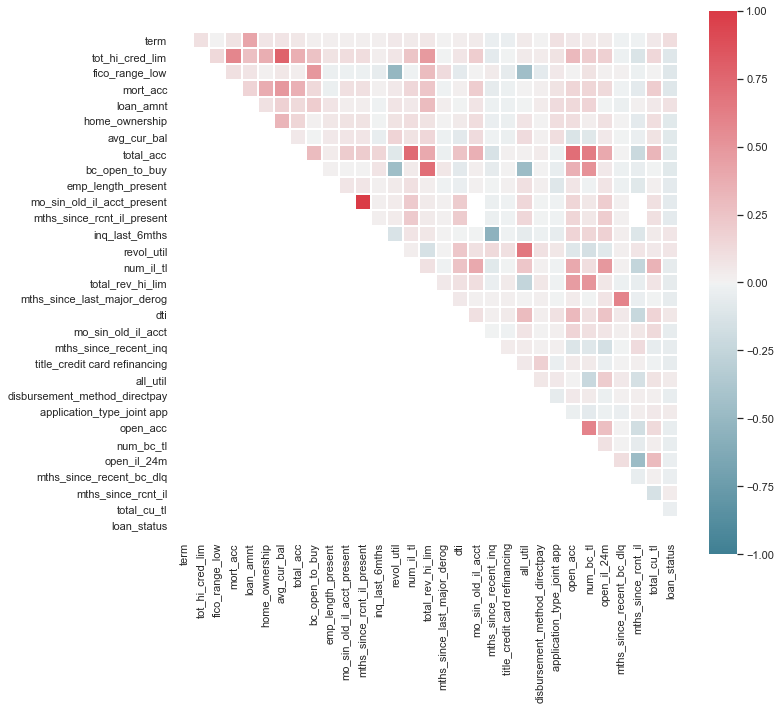

In [17]:
dataViz = data_cleaned
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, 
            square=True, cbar=True, center=0, ax=ax, mask=mask)

#### 5.3 Univariate selection methods - AUC

In [17]:
tmp = X_train.join(y_train)
na_cols = tmp.columns[tmp.isnull().any()]
label = 'loan_status'

In [18]:
# impute missing 
def missing_by_br(df, cols, label):
    tmp = df
    for col in cols:
        tmp['group'] = pd.qcut(tmp[col], 10, duplicates='drop')
        tmp['group'] = np.where(tmp.group.isna(), 'missing', tmp.group).astype(str)
        aa = tmp.groupby('group').agg({col: np.median,label: np.mean}).reset_index().rename(columns={'loan_status':'default_rate'}).sort_values(col).reset_index(drop = True)
        br = aa[aa['group'] == 'missing'].default_rate
        bb = aa.default_rate - br.iloc[0]
        aa['diff'] = bb.abs()
        aa = aa.sort_values('diff')
        imp = aa.iloc[1,2]
        tmp[col] = tmp[col].fillna(imp)
    
    return tmp

In [19]:
tmp = missing_by_br(tmp, na_cols, label)

In [20]:
from sklearn.linear_model import LogisticRegression
auc_df = pd.DataFrame()
for col in tmp.columns[:-2]:
    clf = LogisticRegression()
    X = tmp[col].values.reshape(-1,1)
    y = tmp['loan_status'].values
    clf.fit(X, y)
    y_pred = clf.predict_proba(X)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
    auc = metrics.roc_auc_score(y, y_pred)
    auc_df.loc[col, 'AUC'] = auc


In [21]:
auc_df.sort_values('AUC', ascending=False, inplace=True)

In [22]:
auc_df.head(5)

,AUC
tot_hi_cred_lim,0.599734
mort_acc,0.583598
avg_cur_bal,0.581996
fico_range_low,0.581579
loan_amnt,0.577420


#### 5.4 Feature importance

In [23]:
xgb1 = xgb.XGBClassifier(
    learning_rate =0.01,
    n_estimators=100,
    max_depth=3,
    min_child_weight=3,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1e-5,
    objective= 'binary:logistic',
    verbosity = 0,
    nthread=4,
    scale_pos_weight=1,
    seed=27)

In [24]:
xgb1.fit(X_train, y_train);

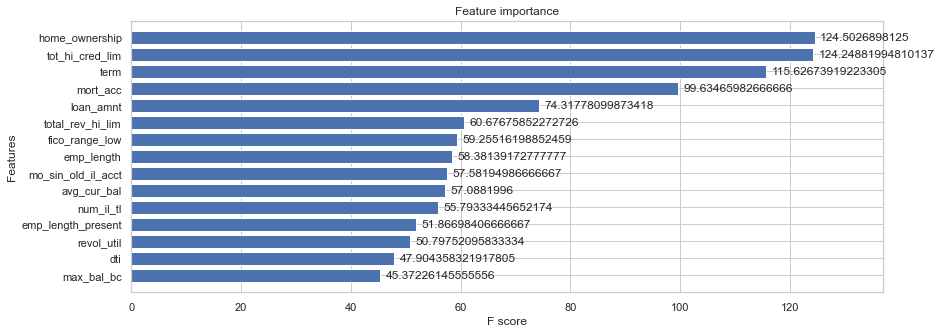

In [25]:
fig, ax = plt.subplots(figsize=(12,5))
xgb.plot_importance(xgb1, max_num_features=15, height=0.8, importance_type='gain', ax=ax)
plt.show()

In [26]:
sorted_idx = np.argsort(xgb1.feature_importances_)[::-1]
ft = pd.DataFrame()
for index in sorted_idx:
    ft.loc[X_train.columns[index], 'feature_imprt'] = xgb1.feature_importances_[index]

In [27]:
ft.head(5)

,feature_imprt
home_ownership,0.087857
tot_hi_cred_lim,0.087678
term,0.081593
mort_acc,0.070308
loan_amnt,0.052443


#### Generate the short list

In [28]:
short_cols = pd.concat([pd.Series(auc_df.index[:20]), linear_dep.variable[:20], pd.Series(ft.index[:20]) ], axis=0).unique()

In [29]:
short_cols

array(['tot_hi_cred_lim', 'mort_acc', 'avg_cur_bal', 'fico_range_low',
       'loan_amnt', 'bc_open_to_buy', 'term', 'home_ownership',
       'total_acc', 'num_il_tl', 'total_rev_hi_lim', 'revol_util',
       'mo_sin_old_il_acct', 'mths_since_recent_inq', 'emp_length',
       'inq_last_6mths', 'dti', 'all_util', 'annual_inc', 'open_il_24m',
       'emp_length_present', 'mo_sin_old_il_acct_present',
       'mths_since_rcnt_il_present', 'mths_since_last_major_derog',
       'max_bal_bc', 'mths_since_rcnt_il', 'revol_bal'], dtype=object)